### 타이타닉2

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras # 딥러닝 lib
import sklearn  # 머신러닝 lib

In [11]:
train = pd.read_csv('train.csv')  # 학습데이터
test = pd.read_csv('test.csv')  # 예측모델
submit = pd.read_csv('gender_submission.csv')

In [12]:
train.isnull().sum()  # 결측치 확인

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [20]:
print(train)

     PassengerId Survived  Pclass  \
0              1       No       3   
1              2      Yes       1   
2              3      Yes       3   
3              4      Yes       1   
4              5       No       3   
..           ...      ...     ...   
886          887       No       2   
887          888      Yes       1   
888          889       No       3   
889          890      Yes       1   
890          891       No       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
88

#### Pclass

Text(0.5, 1.0, 'Cabin per Pclass')

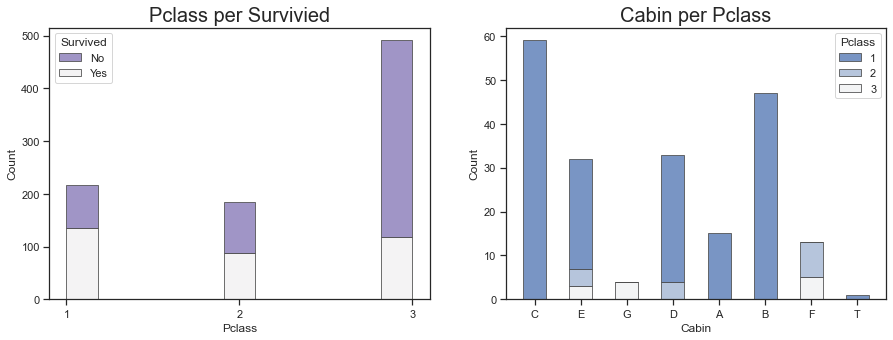

In [15]:
# Survived 보기 쉽게 변환
train['Survived'] = train['Survived'].apply(lambda x: 'Yes' if x==1 else 'No')

# Cabin 알파벳만 추출하기
train['Cabin'].fillna(0, inplace=True)
train['Cabin'] = train['Cabin'].apply(lambda x: x[:1] if type(x)==str else str(x))

f, ax = plt.subplots(1,2,figsize=(15, 5))
sns.set_theme(style="ticks")
sns.histplot(train, x="Pclass", hue="Survived", multiple="stack", palette="light:m_r", edgecolor=".3",linewidth=.8, ax=ax[0])
sns.histplot(train.query("Cabin != '0'"), x="Cabin", hue="Pclass", multiple="stack", palette="light:b_r", edgecolor=".3",linewidth=.8,shrink=0.5, ax=ax[1])
ax[0].set_xticks([1,2,3])

ax[0].set_title('Pclass per Survivied', fontsize=20)
ax[1].set_title('Cabin per Pclass', fontsize=20)

- 3등석 탑승객이 가장 많지만 대부분이 사망자이다
- 1등석의 생존자가 가장 많고 C클래스에 1등석이 가장 많음을 알 수 있다.

#### Name

Text(0.5, 1.0, 'Initial per Age')

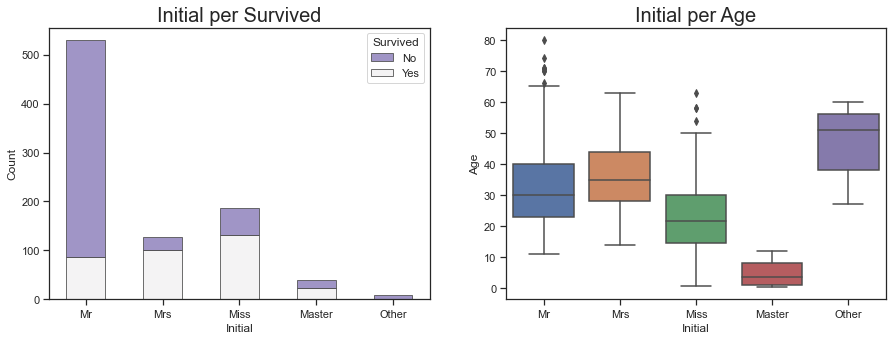

In [30]:
# Name 으로부터 Mr, Mrs 새로운 Initial 칼럼 생성
train['Initial']=0
for i in train:
    train['Initial']=train.Name.str.extract('([A-Za-z]+)\.')  # 추출..?
train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

# plotting
f, ax = plt.subplots(1,2,figsize=(15, 5))
sns.set_theme(style="ticks")
sns.histplot(train, x="Initial", hue="Survived", multiple="stack", palette="light:m_r", edgecolor=".3",linewidth=.8, shrink=0.5, ax=ax[0])
sns.boxplot(data=train, x="Initial", y="Age",ax=ax[1])

ax[0].set_title('Initial per Survived', fontsize=20)
ax[1].set_title('Initial per Age', fontsize=20)

- Mr의 사망율이 제일 크고 Miss의 생존율이 가장 크다.
- 연령이 낮은 층이나 여성인 경우 생존율이 크다는 것을 알 수 있다.

#### Sex

Text(0.5, 1.0, 'Sex per Survived')

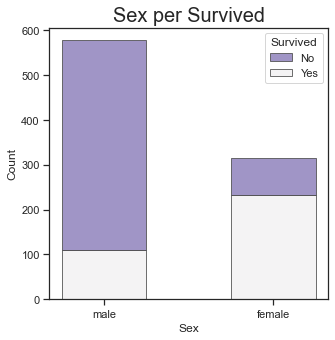

In [21]:
f, ax = plt.subplots(figsize=(5, 5))
sns.set_theme(style="ticks")
sns.histplot(train, x="Sex", hue="Survived", multiple="stack", palette="light:m_r", edgecolor=".3",linewidth=.8, shrink=0.5)
ax.set_title('Sex per Survived', fontsize=20)

- 남성보다 여성의 생존율이 월등히 높다.

#### Age

In [33]:
train.groupby('Initial')['Age'].mean()

Initial
Master     4.616750
Miss      21.887097
Mr        32.798677
Mrs       35.984252
Other     45.888889
Name: Age, dtype: float64

- 이름으로 성별을 예측할 수 있고 groupby를 통해 해당 initial의 평균 연령을 알 수 있다.

Text(0.5, 1.0, 'Age per Survived')

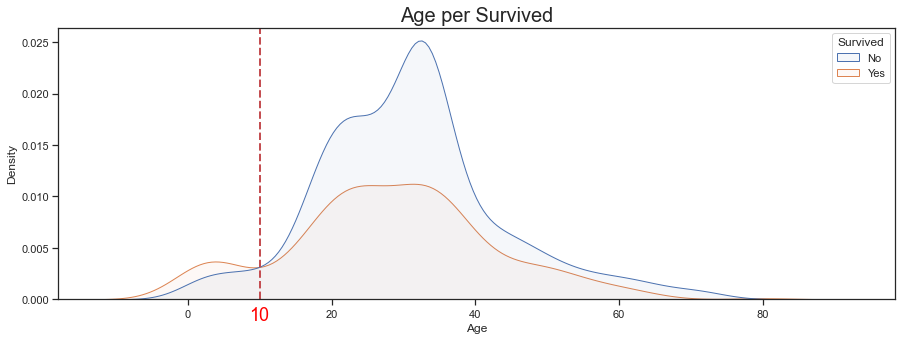

In [32]:
# 결측치 채우기
train.loc[(train.Age.isnull())&(train.Initial=='Mr'),'Age']=33
train.loc[(train.Age.isnull())&(train.Initial=='Mrs'),'Age']=36
train.loc[(train.Age.isnull())&(train.Initial=='Master'),'Age']=5
train.loc[(train.Age.isnull())&(train.Initial=='Miss'),'Age']=22
train.loc[(train.Age.isnull())&(train.Initial=='Other'),'Age']=46

f, ax = plt.subplots(figsize=(15, 5))
sns.set_theme(style="ticks")
sns.kdeplot(data=train, x="Age", hue='Survived',fill=True,alpha=0.05,ax=ax)
ax.axvline(x=10, color='r', linestyle = '--', linewidth=2)
ax.text(8.5,-0.002,'10',fontdict={'color':'red','size':18})
ax.set_title('Age per Survived', fontsize=20)

- 10세 전으로는 생존자가 사망자보다 많지만 10세 이후로는 사망자 수가 더 많다.

#### SibSp

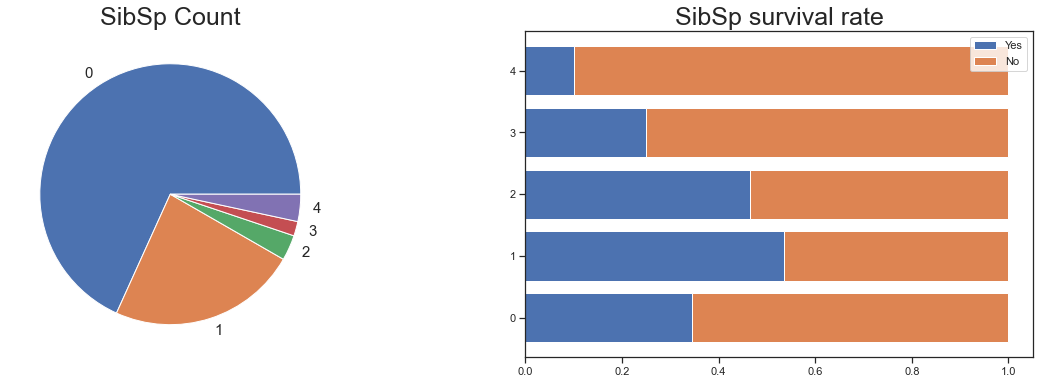

In [35]:
train['SibSp'] = train['SibSp'].apply(lambda x: str(x))
sib_df = train['SibSp'].value_counts().sort_index()

sib_ct = pd.crosstab(train['SibSp'],train['Survived'], margins=True).drop('All',axis=0)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.pie(sib_df, labels = sib_df.index,textprops={'fontsize': 15})
plt.title('SibSp Count', size=25)

plt.subplot(1,2,2)
plt.barh(sib_ct.index,sib_ct['Yes']/sib_ct['All'])
plt.barh(sib_ct.index,sib_ct['No']/sib_ct['All'],left = sib_ct['Yes']/sib_ct['All'])
plt.title('SibSp survival rate', size=25)
plt.legend(['Yes','No'])

# 4 이상으로 그룹 묶기
train['SibSp'] = train['SibSp'].apply(lambda x: str(4) if int(x)>=4 else x)

- 혼자 탑승한 승객이 가장 많았으며 생존율이 4~5인 가족보다 높은편이다.
- 형제, 자매, 배우자수가 0~2인의 경우 생존율이 점차 늘어나지만 4~5인 가족은 생존율이 낮아진다.

#### Parch

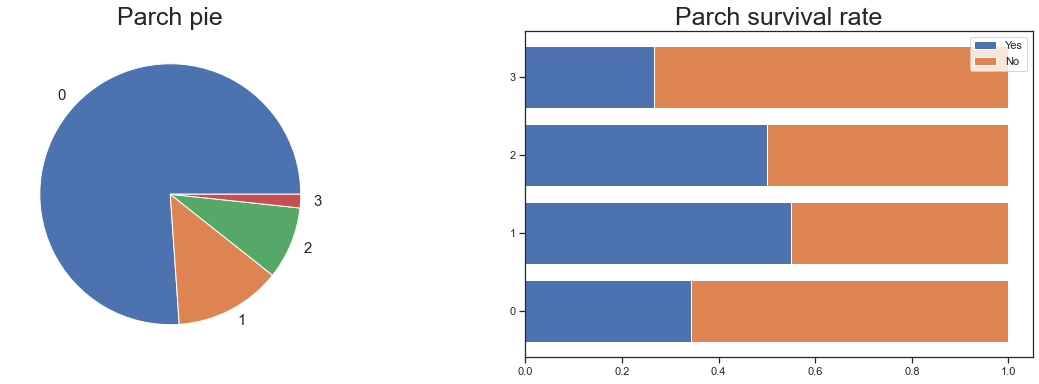

In [37]:
train['Parch'] = train['Parch'].apply(lambda x: str(x))
par_df = train['Parch'].value_counts().sort_index()

par_ct = pd.crosstab(train['Parch'],train['Survived'], margins=True).drop('All',axis=0)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.pie(par_df, labels = par_df.index,textprops={'fontsize': 15})
plt.title('Parch pie', size=25)

plt.subplot(1,2,2)
plt.barh(par_ct.index,par_ct['Yes']/par_ct['All'])
plt.barh(par_ct.index,par_ct['No']/par_ct['All'],left = par_ct['Yes']/par_ct['All'])
plt.title('Parch survival rate', size=25)
plt.legend(['Yes','No'])

# 3 이상은 그룹으로 묶기
train['Parch'] = train['Parch'].apply(lambda x: str(3) if int(x)>=3 else x)

- 부모 자녀가 0일때(..?) 보다 1~2일때 생존율이 더 높고 3이상과는 비슷하다.

#### Ticket

In [ ]:
# Ticket에서 숫자만 추출
tic_num = train['Ticket'].apply(lambda x: x.split(' ')[-1])
train['Ticket'] = tic_num.replace('LINE',0)
train['Ticket'] = train['Ticket'].apply(lambda x: int(x))

# plotting
plt.figure(figsize=(15,10))

plt.subplot(2,2,(1,2))
sns.kdeplot(data=train, x="Ticket", hue='Pclass',palette = 'Set1',fill=True,alpha=0.05)
plt.text(250000, -0.0000003,"↓",fontdict={'color':'red','size':25})
plt.text(2800000, -0.0000003,"↓",fontdict={'color':'red','size':25})
plt.xticks([])
plt.title('Ticket Number per Pclass', size=15)

plt.subplot(2,2,3)
sns.scatterplot(data=train, x="Ticket",y="Fare",hue="Pclass", palette="Set1")
plt.xlim(0,500000)
plt.title('Ticket num : 0 ~ 500000', size=15)

plt.subplot(2,2,4)
sns.scatterplot(data=train, x="Ticket",y="Fare",hue="Pclass", palette="Set1")
plt.xlim(3000000,)
plt.title('Ticket num : 3000000 ~ ', size=15)

#### Fare

#### Cabin

#### Embarked